# ISSUE: chain extension

Fictitious extension of the chain with zero entries should result in a better sampling over the frequencies domain, however I observe unexpected changes into the population of the environmental modes.

In [1]:
using Pkg
Pkg.activate("../QTools")

include("../QTools/src/io.jl")
include("../QTools/src/plots.jl")
include("../QTools/src/jOhmic.jl")
include("../QTools/src/chaincoeffs.jl")
include("../QTools//src/envmodes.jl")
include("../TEBD/src/twoSiteMeas.jl")

using JSON
using MPSDynamics
using DelimitedFiles
using CairoMakie

  Activating project at `c:\Users\andre\Desktop\master-thesis\QTools`


## Compute chain coefficients for enalrged chain

In [4]:
jsonfile = "config.json"
p = JSON.parsefile(jsonfile)

# Provide a chain length different
chain_length = 800 # p["chain"]["size"]

α, s, ωc, κ = p["environment"]["spectral_density_parameters"]
sdf_string = p["environment"]["spectral_density_function"]
ωmax = Float64(p["environment"]["domain"][2])
β = p["environment"]["β"]
nquad = p["environment"]["nquad"]

# using `MPSDynamics.chaincoeffs_finiteT`

# Spectral density base function (positive frequencies)
sdf(x) = (π / 2) * α * κ * ωc .* (x ./ ωc) .^ s .* exp.(- s.* x ./ ωc)
# Full spectral density function over two intervals (negative and positive frequencies)
function J(x, i)
    if i == 1
        return 0
    elseif i == 2
        return -0.5 .* (1 .+ coth.(0.5 .* x .* β)) .* sdf.(abs.(x))
    elseif i == 3
        return 0.5 .* (1 .+ coth.(0.5 .* x .* β)) .* sdf.(abs.(x))
    elseif i == 4
        return 0
    else
        println("Invalid interval index i = $i. Expected 1, 2, 3 or 4.")
    end
end

# Compute chain coefficients: [frequencies, couplings, [κ₀]]
println("Begin calculation of the chain coefficients")
coeff = chaincoeffs_finiteT(
    chain_length,
    β,
    false;
    J = J,                        # custom J(ω)
    mc = 4,                       # intervals
    AB = [[-Inf -ωmax]; [-ωmax 0]; [0 ωmax]; [ωmax Inf]],    # defines the domain of J
    Mmax = nquad,
    save = false,
)
println("Calculation finished")

freqs = coeff[1]
coups = vcat(coeff[3][1], coeff[2])

write_vector("", "freqs$chain_length", freqs)
write_vector("", "coups$chain_length", coups)

# Check correctness of the first chain coefficients by integral calculus
my_freqs, my_coups = check_chaincoeff(p, ωmax)
println("\nCheck first coefficients with integral calculus")
println("Frequencies")
println("\tMe:          $my_freqs")
println("\tMPSDynamics: $(freqs[1:4])")
println()
println("Couplings")
println("\tMe:          $my_coups")
println("\tMPSDynamics: $(coups[1:4])")

Begin calculation of the chain coefficients
Calculation finished

Check first coefficients with integral calculus
Frequencies
	Me:          [1.499788255415969, 2.498976605990238, 3.4878075474797154, 4.382109905869713]
	MPSDynamics: [1.4997882554160145, 2.4989766059903715, 3.4878075474793455, 4.38210990587008]

Couplings
	Me:          [0.39636007157743736, 0.8661241296473888, 1.413400129085452, 1.9178949552577496]
	MPSDynamics: [0.39636007157743247, 0.8661241296473616, 1.413400129085517, 1.9178949552577473]


## Compute frequencies and average occupation number of the environmental modes


In [ ]:
# Real chain length
chainsize = 500

# Extend chain size
larger_chainsize = 1000

# Read chain coefficients
freqs = readdlm("freqs$larger_chainsize.dat", '\n', Float64)[:, 1]
coups = readdlm("coups$larger_chainsize.dat", '\n', Float64)[:, 1]

# Diagonalize tridiagonal matrix
modes, U = diagonalize_tridiagonal(freqs, coups)

# Save normal modes frequencies to .dat file
write_vector("", "envmodes$larger_chainsize", modes)

# While reading chain site occupation measurements,
# compute normal modes occupation and save to .dat file

# Note: first column in 'rawData' is time
rawData = readdlm("measOcc_Up.dat", ',', Complex{Float64}, '\n')

# using 'indDoubleMeas' to list indexes for two site measurements
measIndices = indDoubleMeas(chainsize)

open("envmodesOcc$larger_chainsize.dat", "w") do io

    for (t, row) in enumerate(eachrow(rawData))

        println("$t of $(size(rawData,1))")
        
        # Fill a n_sites × n_sites matrix with the chain sites occupation,
        # needed 'indDoubleMeas' to proper mapping from measurements file
        measMatr = zeros(ComplexF64, larger_chainsize, larger_chainsize)
        for i = 1:length(measIndices)
            measMatr[measIndices[i][1]-1, measIndices[i][2]-1] = rawData[t, i+1]
            measMatr[measIndices[i][2]-1, measIndices[i][1]-1] = rawData[t, i+1]'
        end

        # Compute normal modes occupation and save to .dat file as a single row,
        # each row of file will be the normal modes occupation for each measurements time
        occ = envmodes_occupation(U, measMatr)
        writedlm(io, permutedims(real.(occ)), ',')
    end
end


## Plot the results

In [7]:
chainsize = 500

function plot_envmodes(chainsize, t1, t2, t3; xlims::Union{Array, Nothing}=nothing)

    tsEnv = readdlm("timeEnv_Up.dat", '\n', Float64)[:, 1]
    modes = readdlm("envmodes$chainsize.dat", '\n', Float64)[:, 1]
    occupations = readdlm("envmodesOcc$chainsize.dat", ',', Float64, '\n')

    f = Figure(size = (550, 400))
    ax = Axis(
        f[1, 1],
        xlabel = L"\omega",
        ylabel = L"\langle n_\omega \rangle",
        title = L"N=%$(chainsize)"
    )
    # <nω>
    lines!(ax, modes, occupations[t1, :], color = :royalblue, linestyle = :dot, label = L"\omega_c t = %$(Int(tsEnv[t1]))")
    lines!(ax, modes, occupations[t2, :], color = :royalblue, linestyle = :dash, label = L"\omega_c t = %$(Int(tsEnv[t2]))")
    lines!(ax, modes, occupations[t3, :], color = :royalblue, linestyle = :solid, label = L"\omega_c t = %$(Int(tsEnv[t3]))")

    if !isnothing(xlims)
        xlims!(ax, xlims...)
    end

    ylims!(ax, 0, nothing)

    axislegend(position = :rt, framevisible=false)

    f
end

plot_envmodes (generic function with 1 method)

┌ Info: Saving figure to envmodes500.png
└ @ Main c:\Users\andre\Desktop\master-thesis\QTools\src\plots.jl:3
┌ Info: Saving figure to envmodes800.png
└ @ Main c:\Users\andre\Desktop\master-thesis\QTools\src\plots.jl:3
┌ Info: Saving figure to envmodes1000.png
└ @ Main c:\Users\andre\Desktop\master-thesis\QTools\src\plots.jl:3


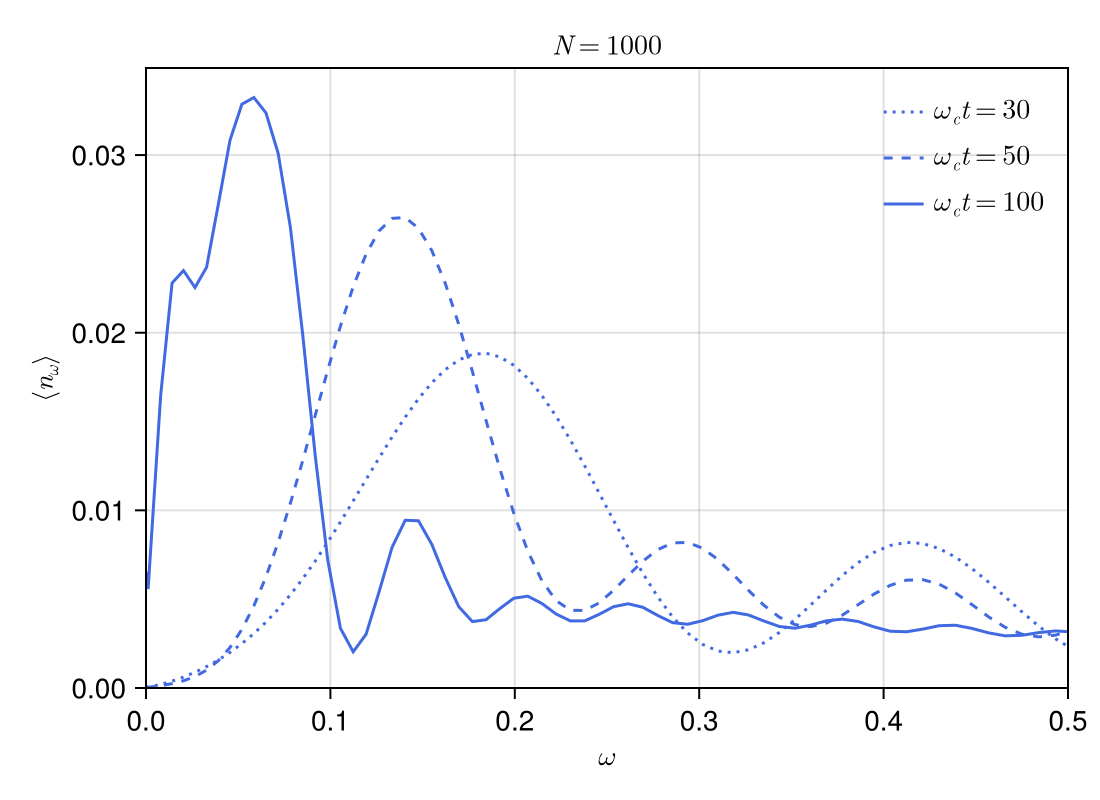

In [10]:
t1, t2, t3 = 31, 51, 101

f = plot_envmodes(500, t1, t2, t3, xlims=[0.0, 0.5])
maybe_save(f, path="envmodes500.png", save=true)

f = plot_envmodes(800, t1, t2, t3, xlims=[0.0, 0.5])
maybe_save(f, path="envmodes800.png", save=true)

f = plot_envmodes(1000, t1, t2, t3, xlims=[0.0, 0.5])
maybe_save(f, path="envmodes1000.png", save=true)

---

The numeration of he sites depends on the total chain-length: if I consider a bigger chain, the index corresponding to a site is not the same fort the larger chain!

In [2]:
chainsize = 2
measIndices = indDoubleMeas(chainsize)

Dict{Int64, Tuple{Int64, Int64}} with 3 entries:
  2 => (2, 3)
  3 => (3, 3)
  1 => (2, 2)

In [3]:
chainsize = 3
measIndices = indDoubleMeas(chainsize)

Dict{Int64, Tuple{Int64, Int64}} with 6 entries:
  5 => (3, 4)
  4 => (3, 3)
  6 => (4, 4)
  2 => (2, 3)
  3 => (2, 4)
  1 => (2, 2)